In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# clean data
import jieba
import jieba.analyse

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mainData = pd.read_csv('蔡英文2.csv', index_col=0, engine='python', encoding='UTF-8')
mainData.head()

,Date,Push,Meeted Count,Voted,Unvoted,Neutral,Author,Title,Content,Push Content,Comment Content,Link
0,2019-01-01 02:09:35,74,73,26.0,13.0,34.0,kid725 (凱道基德),Re: [新聞] 葛來儀否認邀柯文哲訪美 指柯幕僚扭曲事,: 來，我們來看第一篇報導怎麼寫的\n: (葛來儀點名的上報)\n: https://www...,"['新的一年的打臉文呢', '哈哈哈 醋性大發', '是位擅長揍臉的朋友呢', '她中文不好...","['新的一年的打臉文呢', '""促""', '哈哈哈 醋性大發', '是位擅長揍臉的朋友呢',...",/bbs/Gossiping/M.1546279781.A.E70.html
1,2019-01-01 03:54:10,20,20,7.0,4.0,9.0,AmamiTsubasa (天海つばさ),[新聞] 不一樣的元旦 蔡英文明發表上任首次新年,1.媒體來源:\n\n聯合新聞網\n\n2.完整新聞標題:\n\n不一樣的元旦 蔡英文明發表...,"['人名正確，可以開噓了', '總統加油台灣加油', '新年快樂，台灣加油', '挖靠!這幾...","['人名正確，可以開噓了', '總統加油台灣加油', '新年快樂，台灣加油', '2020滅...",/bbs/Gossiping/M.1546286053.A.3D2.html
2,2019-01-01 06:29:45,25,25,14.0,6.0,5.0,Workforme (′‧ω‧‵),[新聞] 迎接2019 蔡總統將發表新年談話,1.媒體來源:\n中央社\n\n2.完整新聞標題:\n迎接2019 蔡總統將發表新年談話\n...,"['冷', '唯一支持蔡總統', '先幫補血', '就把2018年的改幾個字再講一次囉', ...","['空心菜', '冷', '唯一支持蔡總統', '國家級的廢文放送', '幹你娘垃圾B嘴',...",/bbs/Gossiping/M.1546295389.A.53F.html
3,2019-01-01 09:04:01,64,64,30.0,6.0,28.0,Asclepius (天...無言),[新聞] 房市達人：不必陸資來 貪婪之心讓高雄步,1.媒體來源:\n\n經濟日報\n\n2.完整新聞標題:\n\n\n房市達人：不必陸資來 貪...,"['貪婪', '貪婪老人不意外', '吱吱覺青廠公吉娃娃還在崩潰喔 高雄都發大財了ㄟ', '...","['貪婪', '貪婪老人不意外', '吱吱覺青廠公吉娃娃還在崩潰喔 高雄都發大財了ㄟ', '...",/bbs/Gossiping/M.1546304644.A.E40.html
4,2019-01-01 09:05:09,1492,1454,1069.0,87.0,298.0,ccf52881 (ccf52881),[新聞] 【首次元旦談話】蔡英文喊話中國：豬瘟,1.媒體來源:蘋果\n\n\n2.完整新聞標題:【首次元旦談話】蔡英文喊話中國：豬瘟都無法合...,"['推', '說的真好 一堆中國阿Q後裔整天在幻想', '推', '有道理', '藍衛兵...","['垃圾母豬去死', '(', '推', '說的真好 一堆中國阿Q後裔整天在幻想', '...",/bbs/Gossiping/M.1546304711.A.FCB.html


In [3]:
mainData.tail()

,Date,Push,Meeted Count,Voted,Unvoted,Neutral,Author,Title,Content,Push Content,Comment Content,Link
3831,2019-01-31 22:58:45,308,151,64.0,24.0,63.0,taipeixcity (台大金宇彬),[新聞] 800位女醫師登報挺蔡英文 陳水扁：威權,1.媒體來源:\n民視\n\n2.完整新聞標題:\n800位女醫師登報挺蔡英文 陳水扁：威權...,"['要推還噓?', '支持小英 但也同意扁的觀念', '吱吱：你這樣我到底推還噓 哈哈哈哈'...","['要推還噓?', '阿扁早就過氣惹好ㄇ 現在是勇哥的時代', '支持小英 但也同意扁的觀念...",/bbs/Gossiping/M.1548946729.A.057.html
3832,2019-01-31 23:11:12,18,13,8.0,1.0,4.0,blue999 (FLY),[新聞] 下任總統候選人？日媒封「小英最怕的男人,下任總統候選人？日媒封「小英最怕的男人」 韓國瑜大笑\n\n\n高雄市長韓國瑜人氣爆棚，不僅...,"['造神造起來!!!!通通給我造起來!!!!!', '賴神：我呢我呢', '韓神果然棒', ...","['樓下柯文哲爆笑圖：', '造神造起來!!!!通通給我造起來!!!!!', '賴神：我呢我...",/bbs/Gossiping/M.1548947476.A.F55.html
3833,2019-01-31 23:16:54,75,46,17.0,3.0,26.0,bdyjkb (bdyjkb),[新聞] 歐洲議員公開挺台 籲歐盟外交承認台灣,1.媒體來源:\n中央社\n\n2.完整新聞標題:\n歐洲議員公開挺台 籲歐盟外交承認台灣\...,"['先補血', '沒實力不要和人家大小聲', '我不懂一堆美國歐盟挺台的 卻不敢去跟政府說要...","['9.2再度崩潰', '先建交阿 笑你們不敢', '自慰ing', '先補血', '建交之...",/bbs/Gossiping/M.1548947817.A.94C.html
3834,2019-01-31 23:27:08,29,21,10.0,3.0,8.0,NARUTO (鳴人),Re: [新聞] 歐洲議員公開挺台 籲歐盟外交承認台灣,: 1.媒體來源:\n: 中央社\n: 2.完整新聞標題:\n: 歐洲議員公開挺台 籲歐盟外...,"['開戰好啊 人生重來 開戰吧', '他們嘴砲而已啦', '嘴砲支持', '嘴砲要打到那年？...","['開戰好啊 人生重來 開戰吧', '支那不敢打啦，你傻嗎', '每次外國有挺台言行時 台灣...",/bbs/Gossiping/M.1548948432.A.2FB.html
3835,2019-01-31 23:58:08,3,0,0.0,0.0,0.0,cloud72426 (數字只是輔助不是真理),Re: [新聞] 歐洲議員公開挺台 籲歐盟外交承認台灣,: 1.媒體來源:\n: 中央社\n: 2.完整新聞標題:\n: 歐洲議員公開挺台 籲歐盟外...,[],[],/bbs/Gossiping/M.1548950291.A.687.html


In [4]:
pd.to_datetime(mainData['Date']).dt.date.tail()

3831    2019-01-31
3832    2019-01-31
3833    2019-01-31
3834    2019-01-31
3835    2019-01-31
Name: Date, dtype: object

## 1.以推文數除以總回文數畫曲線圖

In [5]:
percentage = mainData['Voted'] / mainData['Meeted Count']
percentage.fillna(value=0, inplace=True)

df = pd.DataFrame({'Ratio': percentage})
df.set_index(pd.to_datetime(mainData['Date']).dt.date, inplace=True)
df.tail()

,Ratio
Date,
2019-01-31,0.423841
2019-01-31,0.615385
2019-01-31,0.369565
2019-01-31,0.476190
2019-01-31,0.000000


In [6]:
grouped = df.groupby(level=0).mean()
average = grouped['Ratio']
grouped

,Ratio
Date,
2019-01-01,0.343291
2019-01-02,0.351376
2019-01-03,0.333743
2019-01-04,0.317705
2019-01-05,0.355698
2019-01-06,0.307822
2019-01-07,0.333053
2019-01-08,0.312071
2019-01-09,0.381826


C:\Users\User\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


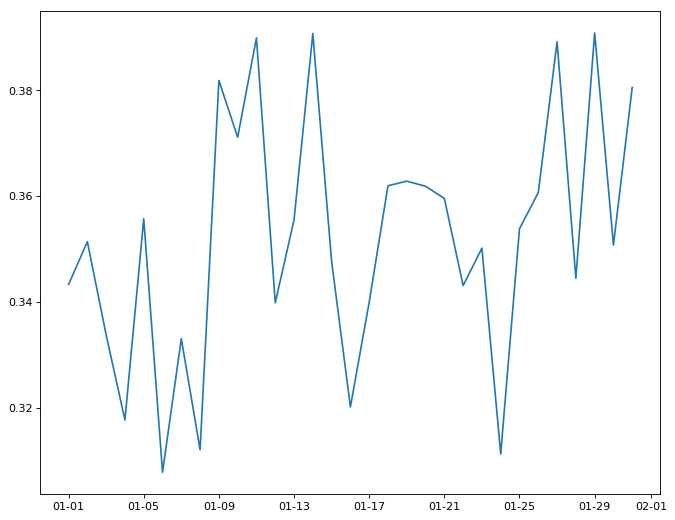

In [7]:
#高低峰圖
import matplotlib.dates as mdate

fig1 = plt.figure(figsize=(10,8), dpi=80)
plt.plot(grouped)
ax2 = fig1.add_subplot(1,1,1)
ax2.xaxis.set_major_formatter(mdate.DateFormatter('%m-%d'))

## 2.判斷高低峰

In [8]:
high = grouped.sort_values('Ratio').head().reset_index()
high

,Date,Ratio
0,2019-01-06,0.307822
1,2019-01-24,0.311275
2,2019-01-08,0.312071
3,2019-01-04,0.317705
4,2019-01-16,0.320157


In [9]:
low = grouped.sort_values('Ratio').tail().reset_index()
low

,Date,Ratio
0,2019-01-09,0.381826
1,2019-01-27,0.389128
2,2019-01-11,0.389870
3,2019-01-14,0.390690
4,2019-01-29,0.390788


## 3.分析高峰出現的文章

### 3.1抓出高峰文章

In [10]:
highData = pd.DataFrame()
for num in range(len(high)):
    data = mainData[mainData['Date'].str.contains(str(high.iloc[num][0]))]
    highData = pd.concat([highData, data])
highData.head()

,Date,Push,Meeted Count,Voted,Unvoted,Neutral,Author,Title,Content,Push Content,Comment Content,Link
1059,2019-01-06 00:01:47,16,14,8.0,3.0,3.0,fonkwei (牽掛),[臉書] 粘拔的幸福碎碎念,臉書卦點說明：昨日香港、明日台灣，這篇寫的超好，文中寫到當年柴契爾夫人與\n鄧小平針對香港主...,"['這種普及文章其實滿重要的 希望大家可以多寫', '事實啊，開始人要崩潰要出來噓惹', '...","['誰 很重要？', '誰', '小英也支持中華民國', '又來測視力 樓下視力多少', '...",/bbs/Gossiping/M.1546704112.A.128.html
1060,2019-01-06 00:03:21,136,136,25.0,63.0,48.0,a10141013 (FlyBall),[新聞] 國民黨:沒九二共識兩岸不會好如何拼經濟,國民黨：沒有九二共識兩岸關係不會好 台灣如何拚經濟\n\n\n2019-01-05 21:0...,"['九二共識是國民黨拿來騙台灣人的東西', '政治零分', '推推 務實', '不會跟其他國...","['ㄏㄏ 跟政黑一樣低能', '習包子:九二共識就是一國兩制', '藍八線經濟有好??', ...",/bbs/Gossiping/M.1546704204.A.3BB.html
1061,2019-01-06 00:05:40,36,36,9.0,14.0,13.0,asynchronous (同步),[新聞] 立委補選何志偉孤軍奮戰？陳思宇：可以,https://www.chinatimes.com/realtimenews/201901...,"['陳的姑姑還在民進黨不分區，這是沙小', '應該找姚文智才對', '王奕凱表示....',...","['兩個垃圾', '政二代酸別人政二代XDDD 台灣真的有病', '白色力量打負面選戰。ㄎㄎ...",/bbs/Gossiping/M.1546704342.A.48B.html
1062,2019-01-06 00:10:58,6,6,0.0,5.0,1.0,bruce0428 (bruce),Re: [新聞] 總統公布了！「大法庭」半年後施行 憲訴,根本問題我們的法院沒guts\n因為法官的判決跟考績綁在一起\n為什麼蔡英文主張廢死\n法官...,"[0, 0, 0, 0, 0, 0]","['你是不是在唬爛', '喜勒工三小', '你先去找一個判決先例再出來嘴', '大巨蛋是行政...",/bbs/Gossiping/M.1546704664.A.8A1.html
1063,2019-01-06 00:14:39,349,346,75.0,19.0,252.0,tonyselina (叫聲拔拔),Re: [新聞] 評蔡英文「一日行情」被噓爆 柯文哲：我,: 標題: Re: [新聞] 評蔡英文「一日行情」被噓爆 柯文哲：我\n: 時間: Sun ...,"['別傻了 白粉只捅民代這種說法。市長也捅了、總統不捅才怪', '柯粉大師兄出現了耶，這次白...","['好歐 2020 DPP請自己加油 絕對不要轉彎跟柯合作歐', '真心不知這種文在開心啥 ...",/bbs/Gossiping/M.1546704883.A.2A3.html


In [11]:
highData.tail()

,Date,Push,Meeted Count,Voted,Unvoted,Neutral,Author,Title,Content,Push Content,Comment Content,Link
2474,2019-01-16 22:14:44,8,7,0.0,3.0,4.0,Syd (Wish you were here),[新聞] 《蝦皮金頭腦》答案錯了！國小數學題「選對卻GG」 網笑：,《蝦皮金頭腦》答案錯了！國小數學題「選對卻GG」 網笑：蝦皮笨頭腦\n\n網搜小組／綜合報導...,"[0, 0, 0, 0, 0, 0, 0]","['先噓個蝦皮', '很多人就是喜歡揪這種小錯以展現自己好像讀很多書...', '真的厲害有...",/bbs/Gossiping/M.1547648097.A.CC3.html
2475,2019-01-16 22:30:45,420,273,178.0,33.0,62.0,Wojnarowski (@wojespn),[爆卦] 蔡英文推特--當選總統三週年,蔡英文總統在推特上發文紀念三年前的勝選之夜，並表示接下來將會繼續帶領台灣前進！\n\n\n推...,"['加油', '推', '中國只有一個頭，就是習大大', '會有幾支？', '加油', '撐...","['五毛開噓', '放心還有5年', '加油', '推', '中國只有一個頭，就是習大大',...",/bbs/Gossiping/M.1547649048.A.447.html
2476,2019-01-16 22:43:17,21,18,9.0,1.0,8.0,hoanbeh (孫南),Re: [新聞] 政大民調／2020總統 蔡英文15.3%第三,: 政大選研民調／2020總統 柯文哲38.7%、朱立倫21.5%、蔡英文15.3%第三\n...,"['只有廠工在推文', '快要可以恢復18趴了，爽欸', '你真4貼心 還幫民進黨著想', ...","['美國:當我死人？', '只有廠工在推文', '快要可以恢復18趴了，爽欸', '你真4貼...",/bbs/Gossiping/M.1547649800.A.00D.html
2477,2019-01-16 23:32:30,107,52,13.0,3.0,36.0,zsdrt (充實過生活),Re: [新聞] 柯文哲民調38％強壓這2人 吳子嘉：頭殼壞,: 三立新聞網\n: 柯文哲民調38％強壓這2人 吳子嘉：頭殼壞才不選總統！\n: 2019...,"['台灣人投爽的 才管不了這麼多', '有人說阿北台北支持度最低，你覺得呢', '反正也沒啥...","['不可質疑你的神', '台灣人投爽的 才管不了這麼多', '民調不是林佳龍本來就輸給盧秀燕...",/bbs/Gossiping/M.1547652753.A.93C.html
2478,2019-01-16 23:36:25,40,28,12.0,5.0,11.0,zoosleep (王者),[新聞] 時力高潞籲小英辭總統任閣揆 陳為廷：紙,1.媒體來源:\n今日新聞\n\n\n2.完整新聞標題:\n\n時力高潞籲小英辭總統任閣揆 ...,"['又有你的話了?', '摸太少', '摸摸', '奶昔哥中肯 這種建議夠廢', '紙牌屋確...","['奶子摸太少', '又有你的話了?', '摸太少', '奶昔哥真閒，還可以看紙牌屋', '...",/bbs/Gossiping/M.1547652993.A.335.html


In [12]:
len(highData)

836

### 3.2切詞

In [13]:
# 字典
jieba.dt.cache_file = 'jieba.cache.new'
jieba.set_dictionary('dict.txt.big')
jieba.load_userdict("dict.txt")

# 停用詞
prog = re.compile('[\s+\.\!\/_,$%^*(+\"\'-]+|[+——→！，。？：:；“”、~@#￥%……&*（）(\d+)「」『』《》【】│]+|[0-9]+|[a-z]', re.I)

stopWords = []
with open('stopWords.txt', 'r', encoding='UTF-8') as file:
    for data in file.readlines():
        data = data.strip()
        stopWords.append(data)

<>:7: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \s
<ipython-input-13-4b0671aafea9>:7: DeprecationWarning: invalid escape sequence \s
  prog = re.compile('[\s+\.\!\/_,$%^*(+\"\'-]+|[+——→！，。？：:；“”、~@#￥%……&*（）(\d+)「」『』《》【】│]+|[0-9]+|[a-z]', re.I)
Building prefix dict from C:\Users\User\atwolin\大學\一下\Data Science Programming\Project\dict.txt.big ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache.new
Loading model cost 1.345 seconds.
Prefix dict has been built succesfully.


In [14]:
# remove number and character
words = []
for word in highData['Content']:
    clean = prog.sub('', word)
    cutWords = jieba.cut(clean, cut_all=False)
    remainderWords = list(filter(lambda a: a not in stopWords and a != '\n', cutWords))
#     print(remainderWords)
    words.append(remainderWords)
words[:5]

[['臉書卦點',
  '說明',
  '昨日',
  '香港',
  '明日',
  '台灣',
  '這篇',
  '寫',
  '超好',
  '文中',
  '寫到',
  '當年',
  '柴契',
  '爾夫人',
  '鄧小平',
  '香港',
  '主權',
  '談判',
  '過程',
  '完全',
  '反映',
  '出現',
  '兩岸關係',
  '阿臉',
  '書',
  '內容',
  '粘拔',
  '手頭',
  '工作',
  '太多要',
  '加班',
  '小時',
  '空檔',
  '打篇文',
  '囉嗦',
  '這篇',
  '香港',
  '故事',
  '參考',
  '各方',
  '直接',
  '進入',
  '正題',
  '老規矩',
  '放',
  '輕鬆',
  '故事',
  '好別',
  '太',
  '認真',
  '前言',
  '先',
  '喚醒',
  '一下',
  '歷史',
  '回憶',
  '年時',
  '大量',
  '白銀',
  '購買',
  '鴉片',
  '而往',
  '外流',
  '嚴重',
  '影響',
  '大清國',
  '經濟',
  '有個',
  '林則徐',
  '清',
  '大臣',
  '搞',
  '禁菸',
  '運動',
  '武力',
  '收繳',
  '外商',
  '鴉片',
  '膏',
  '這人',
  '治世',
  '能臣',
  '興趣',
  '查閱',
  '收繳',
  '之後',
  '奏',
  '道光',
  '集中',
  '公開',
  '虎門',
  '海水',
  '浸化法',
  '消滅',
  '大英帝國',
  '大清國',
  '第一次鴉片戰爭',
  '大清',
  '戰敗',
  '簽屬',
  '南京',
  '條約',
  '永久',
  '割讓',
  '香港島',
  '英國',
  '之後',
  '第二次',
  '鴉片戰爭',
  '大清',
  '戰敗',
  '簽屬',
  '北京',
  '條約',
  '永遠',
  '割讓',
  '九龍半島',
  '給予',
  '英國',
  '英國',
  '大清',
  '發展',
  '香港',

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(words)

# Create Corpus
texts = words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### 3.3 Find the optimal number of topics for LDA

In [16]:
def compute_coherence_values(id2word, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,
                                            random_state=100, update_every=1, chunksize=100,
                                            passes=20, alpha='auto', per_word_topics=True)
        model_list.append(model)

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=model, texts=texts, 
                                             dictionary=id2word, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())
#         print('\nCoherence Score: ', coherence_lda)

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(id2word=id2word, corpus=corpus, texts=words, start=2, limit=40, step=6)

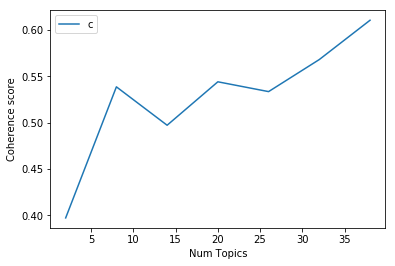

In [20]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3973
Num Topics = 8  has Coherence Value of 0.5387
Num Topics = 14  has Coherence Value of 0.4972
Num Topics = 20  has Coherence Value of 0.5441
Num Topics = 26  has Coherence Value of 0.5335
Num Topics = 32  has Coherence Value of 0.5681
Num Topics = 38  has Coherence Value of 0.6105


In [22]:
optimalCom_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=6,
                                            random_state=100, update_every=1, chunksize=100,
                                            passes=20, alpha='auto', per_word_topics=True)

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimalCom_model, corpus, id2word)
vis

C:\Users\User\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.167823 -0.035472       1        1  32.134838
2     -0.103160  0.150366       2        1  26.976189
5     -0.102455 -0.167345       3        1  21.862597
1     -0.000276  0.151492       4        1   7.935737
4      0.104376 -0.115971       5        1   7.510258
0      0.269337  0.016930       6        1   3.580389, topic_info=      Category         Freq  Term        Total  loglift  logprob
term                                                            
1344   Default  1249.000000   柯文哲  1249.000000  30.0000  30.0000
1249   Default  1294.000000  九二共識  1294.000000  29.0000  29.0000
69     Default  1528.000000    中國  1528.000000  28.0000  28.0000
9      Default   766.000000  一國兩制   766.000000  27.0000  27.0000
179    Default   929.000000    兩岸   929.000000  26.0000  26.0000
261    Default  2985.000000    台灣  2985.000000  25.0000  25.0000
597    Default   631.000000    政府   631.000000  24.0000  24.0000
914    Default   508.000000    經濟   508.000000  23.0000  23.0000
361    Default   661.000000    大陸   661.000000  22.0000  22.0000
909    Default   548.000000    統一   548.000000  21.0000  21.0000
1281   Default   616.000000   習近平   616.000000  20.0000  20.0000
1670   Default   355.000000     柯   355.000000  19.0000  19.0000
80     Default   491.000000  中華民國   491.000000  18.0000  18.0000
1350   Default   329.000000    民調   329.000000  17.0000  17.0000
930    Default   543.000000    美國   543.000000  16.0000  16.0000
1223   Default   158.000000    香港   158.000000  15.0000  15.0000
309    Default   358.000000    回應   358.000000  14.0000  14.0000
1701   Default   366.000000    覺得   366.000000  13.0000  13.0000
312    Default   801.000000    國家   801.000000  12.0000  12.0000
5      Default   327.000000  一個中國   327.000000  11.0000  11.0000
1248   Default   523.000000    不要   523.000000  10.0000  10.0000
1697   Default   138.000000    行情   138.000000   9.0000   9.0000
1614   Default   137.000000    一日   137.000000   8.0000   8.0000
382    Default   397.000000    媒體   397.000000   7.0000   7.0000
25665  Default   257.000000    鳳梨   257.000000   6.0000   6.0000
1001   Default  2212.000000   蔡英文  2212.000000   5.0000   5.0000
2242   Default   245.000000    方案   245.000000   4.0000   4.0000
836    Default   377.000000    真的   377.000000   3.0000   3.0000
3800   Default   154.000000   行政院   154.000000   2.0000   2.0000
924    Default  1235.000000    總統  1235.000000   1.0000   1.0000
...        ...          ...   ...          ...      ...      ...
5378    Topic6    14.613618   愛國者    15.416957   3.2762  -6.1850
25399   Topic6    14.378335    地面    15.194531   3.2745  -6.2012
12657   Topic6    44.026409    口譯    46.712772   3.2705  -5.0821
18314   Topic6    12.610295    一等    13.400771   3.2689  -6.3324
18347   Topic6    12.610295    諮議    13.400771   3.2689  -6.3324
9271    Topic6    11.805768    偵查    12.597070   3.2648  -6.3983
25430   Topic6    11.565107    追究    12.356593   3.2635  -6.4189
25434   Topic6    11.565107    頭部    12.356593   3.2635  -6.4189
25417   Topic6    11.565107    用頭    12.356593   3.2635  -6.4189
25386   Topic6    11.565107    傷的    12.356593   3.2635  -6.4189
25391   Topic6    11.565107  刑事責任    12.356593   3.2635  -6.4189
25395   Topic6    11.565107   周盟翔    12.356593   3.2635  -6.4189
1448    Topic6    12.047150   大法官    12.877982   3.2630  -6.3781
25423   Topic6    11.565107    窮盡    12.356593   3.2635  -6.4189
25385   Topic6    11.565107    傷痕    12.356593   3.2635  -6.4189
25414   Topic6    11.565107    滿大    12.356593   3.2635  -6.4189
25409   Topic6    11.565107    撞牆    12.356593   3.2635  -6.4189
18066   Topic6    17.225088    防空    18.915714   3.2361  -6.0205
12953   Topic6    14.416327     車    15.726096   3.2427  -6.1986
10964   Topic6    19.482019     楊    22.657030   3.1787  -5.8974
265     Topic6    24.778572    司法    30.351345   3.1268  -5.6569
12660   Topic6 

In [33]:
optimalCom_model.save('awarenessPeak_LDA_file')

## 4.分析低峰出現的文章

### 4.1抓出低峰文章

In [24]:
lowData = pd.DataFrame()
for num in range(len(low)):
    data = mainData[mainData['Date'].str.contains(str(low.iloc[num][0]))]
    lowData = pd.concat([lowData, data])
lowData.head()

,Date,Push,Meeted Count,Voted,Unvoted,Neutral,Author,Title,Content,Push Content,Comment Content,Link
1795,2019-01-09 00:10:16,3,3,1.0,0.0,2.0,yggyygy (yggyygy),Re: [問卦] 職場上這種女生是不是很常見?,: 本肥最近跟一位女生共同工作\n: 然後只要做到要搬東西之類的工作\n: 不是很重的東西\...,['肥宅悲歌'],"['肥宅悲歌', '幹 就是有你這種工具人才會助長她們', '子宮哪有那麼容易脫垂']",/bbs/Gossiping/M.1546963818.A.5CE.html
1796,2019-01-09 00:10:57,13,13,5.0,0.0,8.0,iUno (㊣IU我老婆㊣iUno),Re: [新聞] 陸不升高對抗 對蔡留餘地,: 反觀3日國台辦的點名聲明，以及蔡英文首度「不承認九二共識」的說法，2日與3日的央\n: ...,"['美國棒子好大好粗 不能太生氣', '想想當年要是朱立倫選上 今天台灣是如何呢', '朱立...","['給維尼一點面子 不要寫得那麼清楚', '美國棒子好大好粗 不能太生氣', 'https:...",/bbs/Gossiping/M.1546963860.A.E2A.html
1797,2019-01-09 00:13:15,3,3,3.0,0.0,0.0,hello21 (哈里路亞CHANCECE),Re: [新聞] 已羨慕！「口譯哥」趙怡翔外派美國 薪,台灣是法治社會 呵呵\n\n講別人是人治社會\n\n台灣其實檯面下更是人治社會\n\n不然怎...,"['先幫推', '幫高調~ 順便呼叫覺青及新潮流黨工發表一下看法', '覺青看來都死光了！']","['先幫推', '幫高調~ 順便呼叫覺青及新潮流黨工發表一下看法', '覺青看來都死光了！']",/bbs/Gossiping/M.1546963998.A.2E3.html
1798,2019-01-09 00:14:09,75,75,58.0,0.0,17.0,l75cm (175cm剛好及格),Re: [新聞] 陸不升高對抗 對蔡留餘地,: 陸不升高對抗 對蔡留餘地\n: 消息人士透露，對大陸而言，此時要煽動大陸人民的情緒很簡單...,"['台股又要漲一波了', 'https://i.imgur.com/ItlOPjY.jpg'...","['台股又要漲一波了', 'https://i.imgur.com/ItlOPjY.jpg'...",/bbs/Gossiping/M.1546964052.A.DB8.html
1799,2019-01-09 00:19:53,29,29,19.0,2.0,8.0,ZZZZ0 (問號),Re: [新聞] 房價過高…去年新生兒數僅18.1萬 400多,: ※ 引述《fytnship (<(￣︶￣)>)》之銘言：\n: : https://ww...,"['這樣地稅的人再移撥過來，就更涼了，讚讚', '讚讚', '連違建 大樓公共空間 房東繳稅...","['這樣地稅的人再移撥過來，就更涼了，讚讚', '讚讚', '連違建 大樓公共空間 房東繳稅...",/bbs/Gossiping/M.1546964396.A.0F1.html


### 4.2切詞

In [25]:
# remove number and character
wordsLow = []
for word in lowData['Content']:
    clean = prog.sub('', word)
    cutWords = jieba.cut(clean, cut_all=False)
    remainderWords = list(filter(lambda a: a not in stopWords and a != '\n', cutWords))
#     print(remainderWords)
    wordsLow.append(remainderWords)
wordsLow[0]

['本肥',
 '最近',
 '一位',
 '女生',
 '共同',
 '工作',
 '做到',
 '搬東西',
 '工作',
 '很重',
 '東西',
 '女生',
 '出',
 '一點點',
 '力',
 '那位',
 '女生',
 '裝死',
 '一旁',
 '不想',
 '幫忙',
 '先',
 '搬',
 '不想',
 '出力',
 '台灣',
 '職',
 '場上',
 '女生',
 '是不是',
 '很多',
 '有掛',
 '有感',
 '好像',
 '理工科',
 '比較',
 '不會',
 '個個',
 '蔡英文',
 '姐姐',
 '還比',
 '男人',
 '男人',
 '不想',
 '搬',
 '理由',
 '大同小異',
 '東西',
 '輕',
 '一點',
 '會長',
 '肌肉',
 '會變',
 '金剛',
 '芭比',
 '東西',
 '真的',
 '蠻重',
 '出個',
 '五成',
 '力說',
 '搬',
 '不動',
 '女生',
 '其實',
 '真的',
 '適合',
 '搬',
 '重物',
 '姿勢',
 '不對',
 '出',
 '力點',
 '不對',
 '好像',
 '子宮',
 '脫垂',
 '危險',
 '不像',
 '男',
 '肥宅',
 '從小',
 '搬',
 '接受',
 '長輩',
 '教導',
 '知道',
 '搬',
 '不會',
 '腰',
 '受傷',
 '常常',
 '女生',
 '搬東西',
 '姿勢',
 '明明',
 '超',
 '容易',
 '閃到',
 '配',
 '穿著',
 '那種',
 '姿勢',
 '看到',
 '奶',
 '屁股',
 '線',
 '默許',
 '惦',
 '惦',
 '盯',
 '不會',
 '第一',
 '出面',
 '糾正']

In [26]:
# Create Dictionary
id2wordLow = corpora.Dictionary(words)

# Create Corpus
textsLow = wordsLow

# Term Document Frequency
corpusLow = [id2wordLow.doc2bow(text) for text in textsLow]

### 4.3 Find the optimal number of topics for LDA

In [28]:
# Can take a long time to run.
# modelLow_list, coherenceLow_values = compute_coherence_values(id2word=id2wordLow, corpus=corpusLow, texts=wordsLow, start=2, limit=40, step=6)

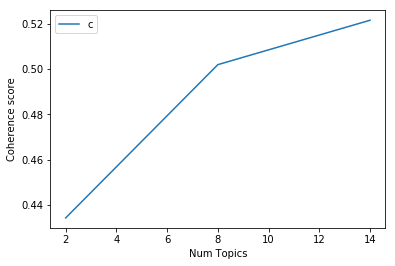

In [36]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherenceLow_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
# Print the coherence scores
for m, cv in zip(x, coherenceLow_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4343
Num Topics = 8  has Coherence Value of 0.502
Num Topics = 14  has Coherence Value of 0.5216
Num Topics = 20  has Coherence Value of nan
Num Topics = 26  has Coherence Value of nan
Num Topics = 32  has Coherence Value of nan
Num Topics = 38  has Coherence Value of nan


In [31]:
optimalLow_model = gensim.models.ldamodel.LdaModel(corpus=corpusLow, id2word=id2wordLow, num_topics=5,
                                            random_state=100, update_every=1, chunksize=100,
                                            passes=20, alpha='auto', per_word_topics=True)

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimalLow_model, corpusLow, id2wordLow)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.269194  0.062666       1        1  74.491936
4     -0.020089 -0.193037       2        1  13.648762
3      0.098494  0.046454       3        1   6.274524
1      0.100546  0.081824       4        1   5.189850
0      0.090243  0.002093       5        1   0.394924, topic_info=      Category         Freq  Term        Total  loglift  logprob
term                                                            
261    Default  1004.000000    台灣  1004.000000  30.0000  30.0000
69     Default   404.000000    中國   404.000000  29.0000  29.0000
1249   Default   285.000000  九二共識   285.000000  28.0000  28.0000
1001   Default  1098.000000   蔡英文  1098.000000  27.0000  27.0000
930    Default   244.000000    美國   244.000000  26.0000  26.0000
179    Default   256.000000    兩岸   256.000000  25.0000  25.0000
9      Default   187.000000  一國兩制   187.000000  24.0000  24.0000
1281   Default   158.000000   習近平   158.000000  23.0000  23.0000
1344   Default  1010.000000   柯文哲  1010.000000  22.0000  22.0000
1743   Default   128.000000    臉書   128.000000  21.0000  21.0000
1013   Default   383.000000    表示   383.000000  20.0000  20.0000
312    Default   233.000000    國家   233.000000  19.0000  19.0000
597    Default   298.000000    政府   298.000000  18.0000  18.0000
719    Default   213.000000    民眾   213.000000  17.0000  17.0000
1      Default    90.000000    一中    90.000000  16.0000  16.0000
116    Default   177.000000    人民   177.000000  15.0000  15.0000
2516   Default    72.000000     讚    72.000000  14.0000  14.0000
5407   Default    53.000000    飛彈    53.000000  13.0000  13.0000
361    Default   100.000000    大陸   100.000000  12.0000  12.0000
80     Default    95.000000  中華民國    95.000000  11.0000  11.0000
909    Default    98.000000    統一    98.000000  10.0000  10.0000
914    Default   129.000000    經濟   129.000000   9.0000   9.0000
67     Default   102.000000    中共   102.000000   8.0000   8.0000
542    Default   119.000000    指出   119.000000   7.0000   7.0000
1285   Default   133.000000   蔡總統   133.000000   6.0000   6.0000
714    Default    93.000000    民主    93.000000   5.0000   5.0000
8473   Default    50.000000    薪資    50.000000   4.0000   4.0000
309    Default   125.000000    回應   125.000000   3.0000   3.0000
600    Default   105.000000    政策   105.000000   2.0000   2.0000
316    Default    92.000000    國際    92.000000   1.0000   1.0000
...        ...          ...   ...          ...      ...      ...
13924   Topic5     0.101695    帳冊     0.661893   3.6611  -8.2271
17279   Topic5     0.101695    獲准     0.661893   3.6611  -8.2271
16526   Topic5     0.101695    邀約     0.661893   3.6611  -8.2271
1875    Topic5     0.101695    檢調     0.661893   3.6611  -8.2271
11324   Topic5     0.101695    高檔     0.661893   3.6611  -8.2271
13733   Topic5     0.101695    貪心     0.661893   3.6611  -8.2271
21258   Topic5     0.101695    高價     0.661893   3.6611  -8.2271
3050    Topic5     1.234544   鄭文燦     8.069499   3.6568  -5.7307
15966   Topic5     0.101695    罪嫌     0.661893   3.6611  -8.2271
18951   Topic5     0.101695    愛將     0.661893   3.6611  -8.2271
4193    Topic5     0.101695    昨以     0.661893   3.6611  -8.2271
1036    Topic5     0.101695    註明     0.661893   3.6611  -8.2271
16294   Topic5     0.186356    引爆     1.256789   3.6256  -7.6215
2540    Topic5     0.241601    一屆     1.657950   3.6082  -7.3618
5567    Topic5     0.101695    被控     0.661893   3.6611  -8.2271
5602    Topic5     0.822591    業者     7.336516   3.3461  -6.1366
5503    Topic5     0.228478    並說     2.023445   3.3531  -7.4177
11880   Topic5     0.585144    副手     8.845692   2.8184  -6.4773
3014    Topic5     0.797009    桃園    20.607286   2.2817  -6.1682
6126    Topic5     0.313841    見證     5.344283   2.6993  -7.1002
14947   Topic5     0.189561    汽車     2.444427   2.9774  -7.6044
1503    Topic5     0.207863    案件     3.805305   2.6270  -7.5122
3802

In [34]:
optimalLow_model.save('awarenessOffPeak_LDA_file')